In [1]:
# Import the essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for our plots for better aesthetics
sns.set_style('whitegrid')

In [3]:
# Use the 'python' engine to handle potential formatting errors in the file
df = pd.read_csv('IMDb movies.csv', engine='python')

In [4]:
# Display the first 5 rows of the dataset
print("First 5 rows of the data:")
print(df.head())

# Get a summary of the data types and missing values
print("\nData Info:")
df.info()

First 5 rows of the data:
  imdb_title_id                        title               original_title  \
0     tt0000009                   Miss Jerry                   Miss Jerry   
1     tt0000574  The Story of the Kelly Gang  The Story of the Kelly Gang   
2     tt0001892               Den sorte drøm               Den sorte drøm   
3     tt0002101                    Cleopatra                    Cleopatra   
4     tt0002130                    L'Inferno                    L'Inferno   

   year date_published                      genre  duration           country  \
0  1894     1894-10-09                    Romance        45               USA   
1  1906     1906-12-26    Biography, Crime, Drama        70         Australia   
2  1911     1911-08-19                      Drama        53  Germany, Denmark   
3  1912     1912-11-13             Drama, History       100               USA   
4  1911     1911-03-06  Adventure, Drama, Fantasy        68             Italy   

  language              

In [5]:
# Remove rows where 'budget' or 'worlwide_gross_income' are missing
df.dropna(subset=['budget', 'worlwide_gross_income'], inplace=True)

In [6]:
# Define a function to clean currency columns
def clean_currency(x):
    if isinstance(x, str):
        return int(x.replace('$', '').strip())
    return int(x)

# Apply the function to the budget and income columns
df['budget_usd'] = df['budget'].apply(clean_currency)
df['income_usd'] = df['worlwide_gross_income'].apply(clean_currency)

ValueError: invalid literal for int() with base 10: 'NOK 250000'

In [7]:
# Import the regular expression library
import re

# Define a more robust function to clean currency columns
def clean_currency(x):
    # Ensure the input is a string, then remove all non-digit characters
    cleaned_string = re.sub(r'[^0-9]', '', str(x))

    # If the string is not empty after cleaning, convert it to an integer
    if cleaned_string:
        return int(cleaned_string)
    # If the string is empty (e.g., it was just '$'), return 0
    else:
        return 0

# Apply the new, improved function to the budget and income columns
df['budget_usd'] = df['budget'].apply(clean_currency)
df['income_usd'] = df['worlwide_gross_income'].apply(clean_currency)

# You can also check the first few rows to see the result
print(df[['title', 'budget', 'budget_usd', 'worlwide_gross_income', 'income_usd']].head())

                                   title      budget  budget_usd  \
165     Il gabinetto del dottor Caligari     $ 18000       18000   
210                        Markens grøde  NOK 250000      250000   
245  I quattro cavalieri dell'Apocalisse    $ 800000      800000   
251                           Il monello    $ 250000      250000   
348                   La donna di Parigi    $ 351000      351000   

    worlwide_gross_income  income_usd  
165                $ 8811        8811  
210                $ 4272        4272  
245             $ 9183673     9183673  
251               $ 26916       26916  
348               $ 11233       11233  


In [8]:
# Calculate the profit for each movie
df['profit_usd'] = df['income_usd'] - df['budget_usd']

Question 1: What are the top 10 most profitable movies?

/tmp/ipython-input-151727844.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='profit_usd', y='title', data=top_10_profitable, palette='viridis')


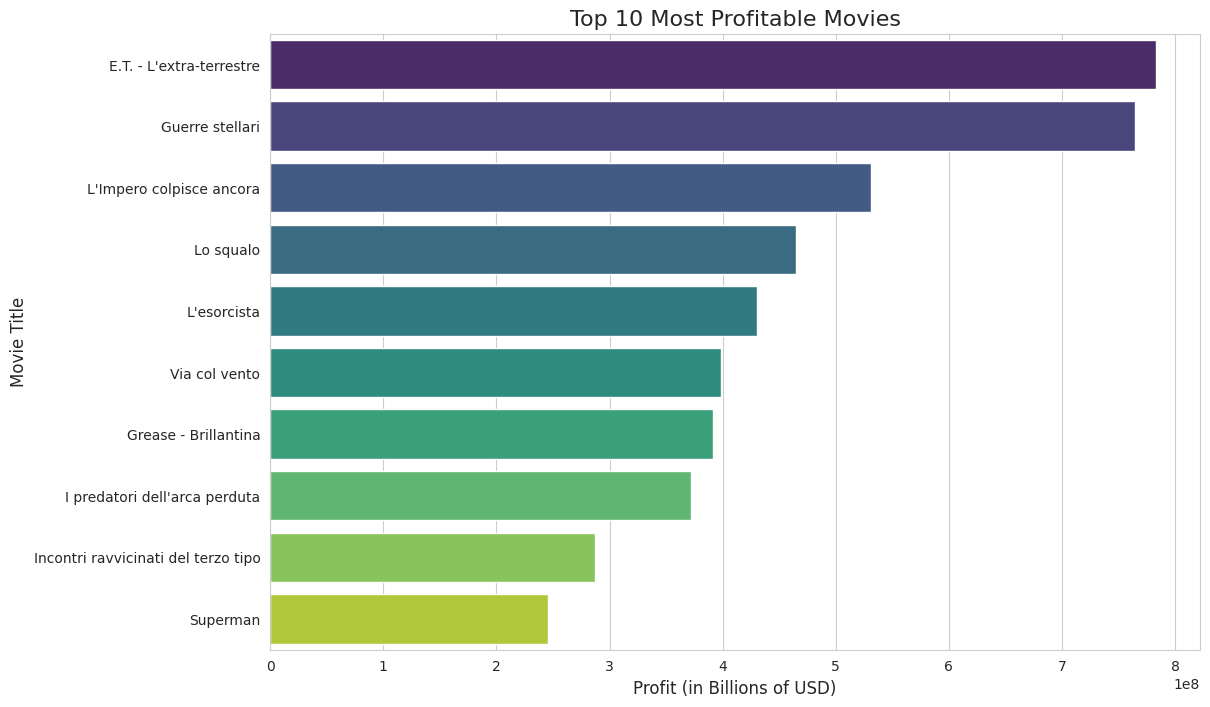

In [9]:
# Sort the DataFrame by profit in descending order and get the top 10
top_10_profitable = df.sort_values(by='profit_usd', ascending=False).head(10)

# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='profit_usd', y='title', data=top_10_profitable, palette='viridis')
plt.title('Top 10 Most Profitable Movies', fontsize=16)
plt.xlabel('Profit (in Billions of USD)', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

Question 2: Is there a correlation between budget and worldwide gross income?

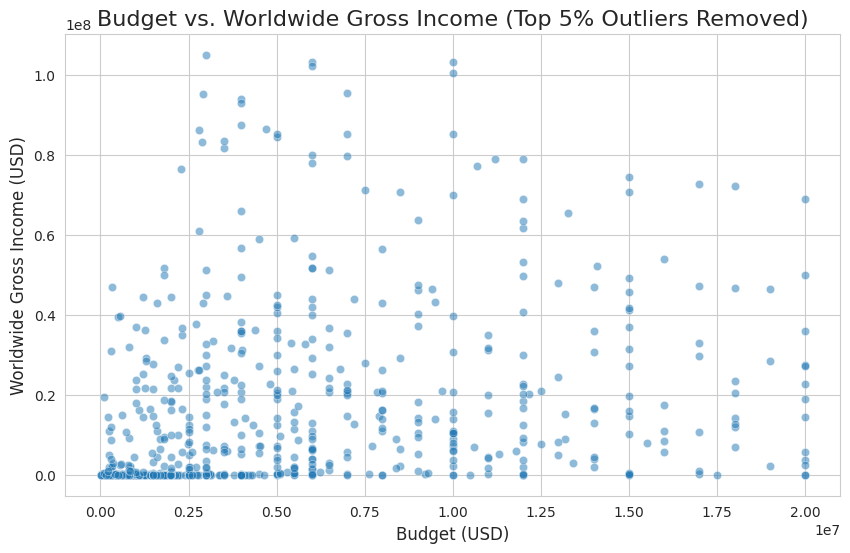

In [11]:
# To get a more meaningful plot, let's remove the most extreme outliers.
# We'll set a cap at the 95th percentile for both budget and income.
budget_cap = df['budget_usd'].quantile(0.95)
income_cap = df['income_usd'].quantile(0.95)

# Create a new DataFrame that only includes movies within these limits.
df_filtered = df[(df['budget_usd'] < budget_cap) & (df['income_usd'] < income_cap)]

# --- Now, create the scatter plot again using the FILTERED data ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget_usd', y='income_usd', data=df_filtered, alpha=0.5)
plt.title('Budget vs. Worldwide Gross Income (Top 5% Outliers Removed)', fontsize=16)
plt.xlabel('Budget (USD)', fontsize=12)
plt.ylabel('Worldwide Gross Income (USD)', fontsize=12)
plt.show()

Question 3: How has the popularity of different genres changed over the decades?

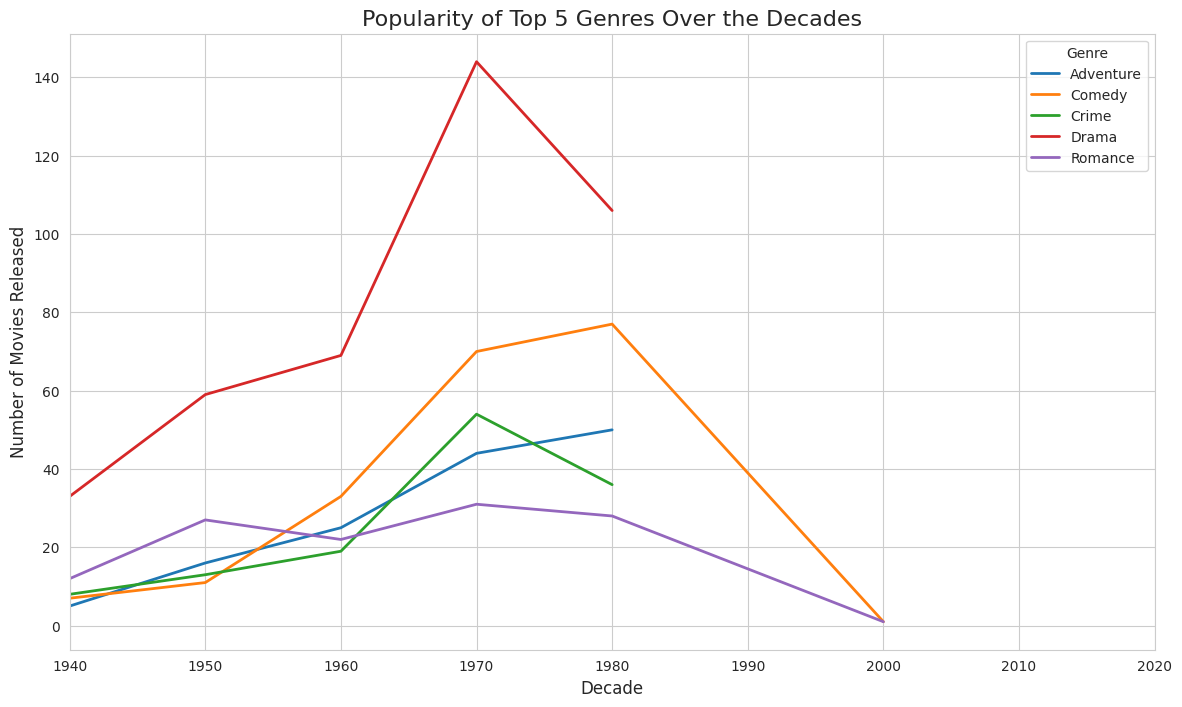

In [12]:
# Create a 'decade' column
df['decade'] = (df['year'] // 10) * 10

# Split genres string into a list and create a row for each genre
df_genres = df.assign(genre=df['genre'].str.split(', ')).explode('genre')

# Get the top 5 most frequent genres to avoid a cluttered plot
top_genres = df_genres['genre'].value_counts().nlargest(5).index

# Filter the DataFrame to include only the top genres
df_top_genres = df_genres[df_genres['genre'].isin(top_genres)]

# Group by decade and genre to count the number of movies
genre_trends = df_top_genres.groupby(['decade', 'genre']).size().reset_index(name='movie_count')

# Create the line chart
plt.figure(figsize=(14, 8))
sns.lineplot(x='decade', y='movie_count', hue='genre', data=genre_trends, lw=2)
plt.title('Popularity of Top 5 Genres Over the Decades', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Movies Released', fontsize=12)
plt.legend(title='Genre')
plt.xlim(1940, 2020) # Focusing on a relevant time period
plt.show()

Question 4: Who are the top 5 directors with the highest average movie ratings?

In [13]:
# Group by director and calculate their average rating and movie count
director_stats = df.groupby('director')['avg_vote'].agg(['mean', 'count'])

# Filter out directors who have directed fewer than 10 movies
qualified_directors = director_stats[director_stats['count'] >= 10]

# Sort by the average rating and get the top 5
top_5_directors = qualified_directors.sort_values(by='mean', ascending=False).head(5)

print("Top 5 Directors by Average Rating (min. 10 movies):")
print(top_5_directors)

Top 5 Directors by Average Rating (min. 10 movies):
                              mean  count
director                                 
Alfred Hitchcock          7.787500     16
Billy Wilder              7.700000     11
Rainer Werner Fassbinder  7.270588     17
John Huston               7.141667     12


Question 5: What is the distribution of movie runtimes?

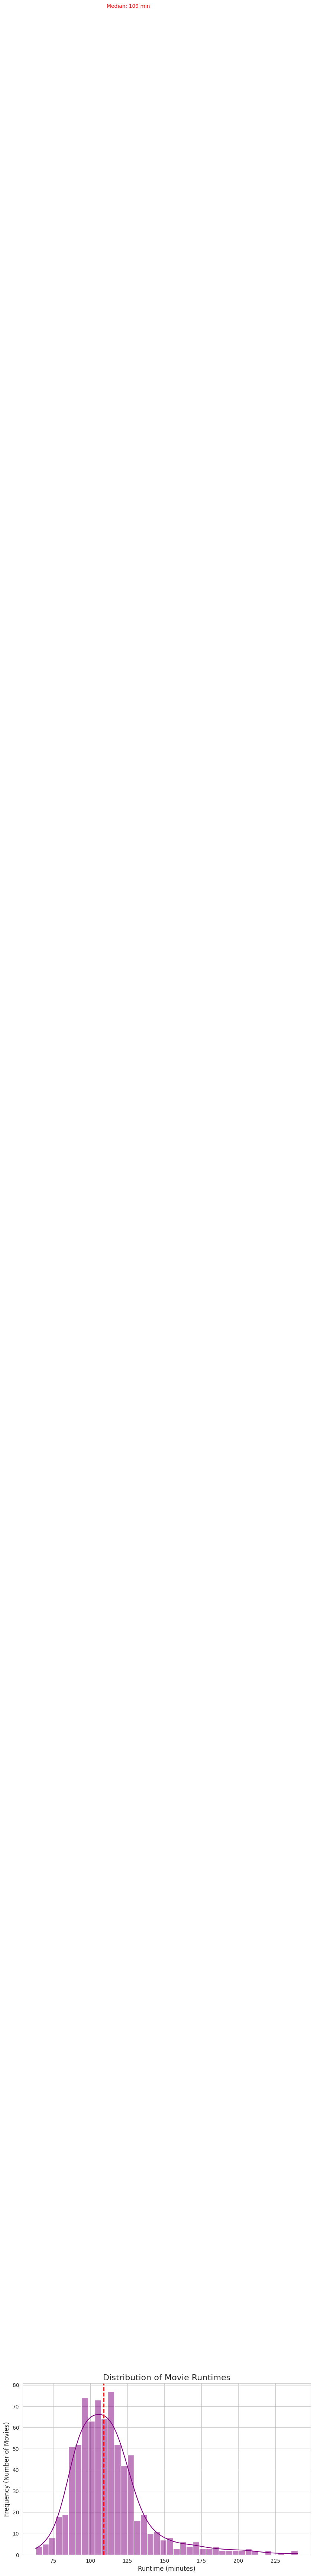

In [14]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=40, kde=True, color='purple')
plt.title('Distribution of Movie Runtimes', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Frequency (Number of Movies)', fontsize=12)
plt.axvline(df['duration'].median(), color='red', linestyle='dashed', linewidth=2)
plt.text(df['duration'].median()+2, 1200, f'Median: {int(df["duration"].median())} min', color = 'red')
plt.show()